In [212]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [213]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [214]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [215]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.G = 100.00
ss.B_G = 50.00
ss.tau = 0.68
solving for household behavior: result.converged = True
ss.C = 49.27
ss.B = 119.18
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = nan
ss.M = nan
par.phi = 0.951


**Household behavior:**

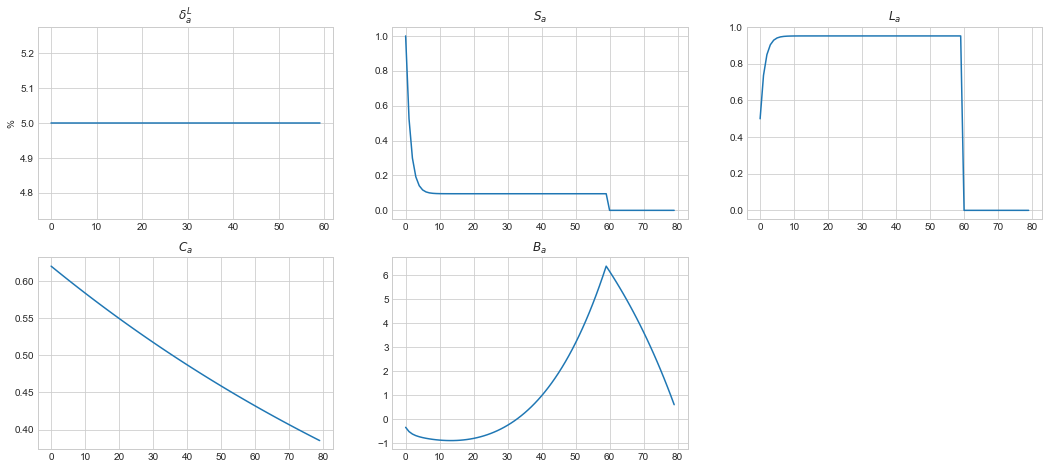

In [216]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [217]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [218]:
%time model.evaluate_blocks(py=True)

CPU times: user 1.48 s, sys: 33.2 ms, total: 1.52 s
Wall time: 1.52 s


**Check errors:**

In [219]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 1.22e-02
Bq_match            : abs. max = 6.93e+02
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 1.67e+01
repacking_prices_C  : abs. max = 0.00e+00


**First numba evaluation:**

In [220]:
%time model.evaluate_blocks()

CPU times: user 17.2 s, sys: 277 ms, total: 17.5 s
Wall time: 17.5 s


**Time:**

In [221]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

3.98 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
28.6 µs ± 360 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [222]:
%timeit model.evaluate_blocks(py=True)

160 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Find an impulse-response

**Calculate Jacobian:**

In [223]:
model.calc_jac(do_print=True)

Jacobian calculated in 12.5 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [224]:
model.set_exo_ss()

Here we shock export demand:

In [225]:
# Tshock = 50
# shock = 0.01*ss.chi
# persistence = 0.8**np.arange(Tshock)
# sol.chi[:Tshock] = ss.chi + shock*persistence

Here we shock the import price of consumption goods (P_M_C):

In [226]:
Tshock_1 = 15
#Tshock_2 = 60
shock_1 = 0.2*ss.P_M_C
#shock_2 = 0.2*ss.P_M_C
persistence_1 = 0.90**np.arange(Tshock_1)
#persistence_2 = 0.85**np.arange(Tshock_2-Tshock_1)
sol.P_M_C[:Tshock_1] = ss.P_M_C + shock_1*persistence_1
#sol.P_M_C[Tshock_1:Tshock_2] += shock_2*persistence_2

In [227]:
# def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        # shock_f = shock_size
        # persistence_f = persistence_size ** np.arange(time_span)
        # solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [228]:
# guide: shock_func(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8)
# shock_func_ny(ss.tau,sol.tau, shock_size = -0.1, persistence_size =0.5)

Check errors when guessing at steady state -> excess demand

In [229]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 1.22e-02
Bq_match            : abs. max = 2.00e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 0.00e+00
repacking_prices_C  : abs. max = 6.04e-02


**Find IRF:**

In [230]:
model.find_IRF()

initial:
   max. abs. error = 6.04e-02
    1.22e-02 in bargaining_cond
    2.00e-13 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    0.00e+00 in mkt_clearing
    6.04e-02 in repacking_prices_C

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 6.04e-02
    1.34e-02 in bargaining_cond
    1.50e+01 in Bq_match
    1.10e-03 in FOC_capital_agency
    7.33e-02 in FOC_K_ell
    1.17e+00 in mkt_clearing
    4.46e-03 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 1.50e+01
    3.24e-03 in bargaining_cond
    4.89e+00 in Bq_match
    1.13e-04 in FOC_capital_agency
    1.63e-02 in FOC_K_ell
    4.04e-01 in mkt_clearing
    1.27e-03 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.89e+00
    2.33e-03 in bargaining_cond
    2.84e+00 in Bq_match
    3.18e-04 in FOC_capital_agency
    1.19e-02 in FO

**Plot:**

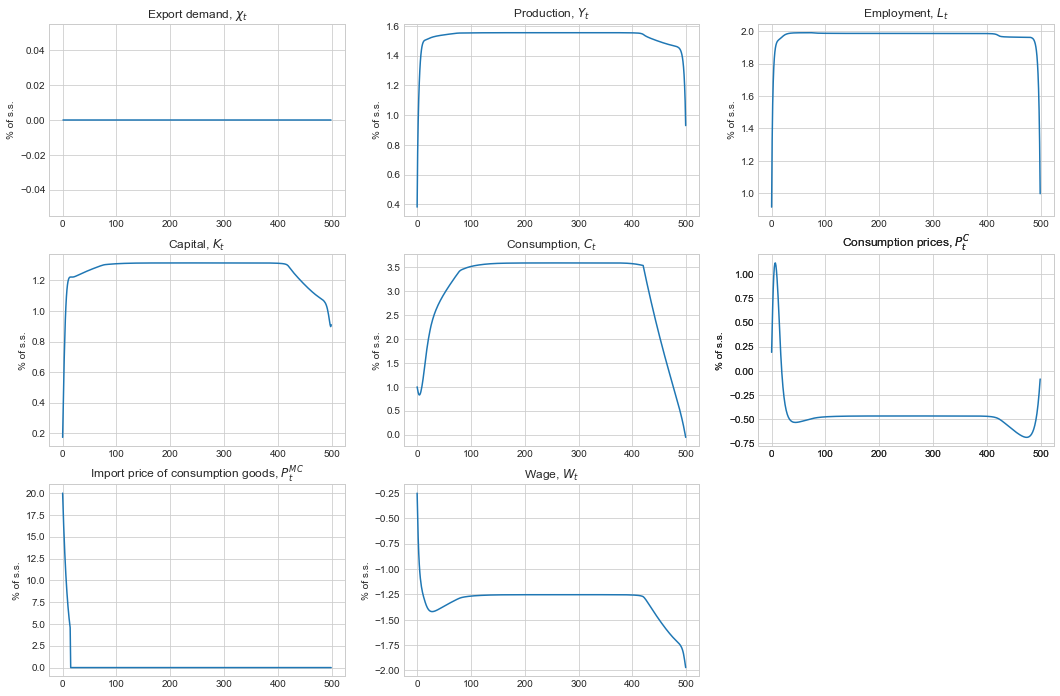

In [231]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.P_C[:T_IRF])/(ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$');

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.P_C[:T_IRF])/(ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$');

ax = fig.add_subplot(3,3,7)
ax.plot(((sol.P_M_C[:T_IRF])/(ss.P_M_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import price of consumption goods, $P^{MC}_t$');

ax = fig.add_subplot(3,3,8)
ax.plot(((sol.w[:T_IRF])/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Wage, $W_t$');

In [207]:
ss.w

2.6814359550285154

In [208]:
2.6814359550285154

2.6814359550285154

In [211]:
sol.MPL[0:100]-sol.r_ell[0:100]

array([-0.00217004,  0.00298312,  0.00579783,  0.00771908,  0.00921924,
        0.01044942,  0.0114596 ,  0.01227521,  0.01292623,  0.01344803,
        0.01387579,  0.01424002,  0.01456476,  0.01486778,  0.01516166,
        0.01545512,  0.01571921,  0.01594526,  0.01613295,  0.01628517,
        0.01640578,  0.01649942,  0.01656969,  0.01661971,  0.01665221,
        0.01666961,  0.01667921,  0.01668118,  0.01667625,  0.01666528,
        0.01664913,  0.01662857,  0.0166043 ,  0.01657693,  0.01654697,
        0.01651488,  0.01648103,  0.01644574,  0.01640929,  0.0163719 ,
        0.01633378,  0.01629508,  0.01625595,  0.0162165 ,  0.01617682,
        0.01613701,  0.01609711,  0.0160572 ,  0.0160173 ,  0.01597746,
        0.01593771,  0.01589805,  0.01585852,  0.01581911,  0.01577985,
        0.01574073,  0.01570175,  0.01566292,  0.01562424,  0.0155857 ,
        0.0155473 ,  0.01550904,  0.01547091,  0.0154329 ,  0.015395  ,
        0.01535722,  0.01531954,  0.01528196,  0.01524447,  0.01